# Backtesting a trading strategy

If you are trying to build a systematic trading strategy, the most important element is coming up with an idea to test! However, how do you go about testing it? There are several elements, which we need when backtesting a trading strategy (by no means an exhaustive list):

* Price data for assets we want to trade - calculate returns from these
* Trading signals, buy/sells - which can be represented as vector of +1/0/-1
* Parameters for transaction costs - in basis point
* Asset weighting - equal weighted, vol weighted etc.

At it's simplest level it involves multiplying a vector of asset returns by a vector of signals. Typically, by far the most time is spent (for obvious reasons!) creating the trading signal. However, the rest of the process can be very similar no matter what trading strategy you run. In PyThalesians, I've tried to make it relatively easy to backtest trading strategies, by createing a template which can be easily adapted to the assets you are trading with your own signals. 

In pythalesians/pythalesians_examples/backtest/strategyfxcta_example.py I have given an example of a simple trend following strategy for G10 FX, which we shall now go through. The first step involves adding our pythalesians library to the Python path (if you have installed it via pip you won't need to do this)

In [1]:
import sys

try:
    sys.path.append('E:/Remote/pythalesians')
except:
    pass

We now do all the various import statements for the various components that we'll use later.

In [2]:
import datetime

from pythalesians.util.loggermanager import LoggerManager

from pythalesians.backtest.popular.strategytemplate import StrategyTemplate # generatic backtesting class 

from pythalesians.market.requests.backtestrequest import BacktestRequest    # for specifying parameters of backtest
from pythalesians.market.loaders.lighttimeseriesfactory import LightTimeSeriesFactory  # for downloading mkt data
from pythalesians.market.requests.timeseriesrequest import TimeSeriesRequest           # parameters for downloading mkt data

from pythalesians.timeseries.techind.techindicator import TechIndicator     # calculating technical indicators

Make sure all plots are done in the notebook as opposed to external windows.

In [3]:
%matplotlib inline

We create a subclass of StrategyTemplate, which acts as an generic template for a trading strategy. The first step is specifiy various parameters such as the trading strategy name, where output files should be dumped and the size of plots.

In [4]:
class StrategyFXCTA_Example(StrategyTemplate):

    def __init__(self):
        super(StrategyTemplate, self).__init__()
        self.logger = LoggerManager().getLogger(__name__)

        ##### FILL IN WITH YOUR OWN PARAMETERS FOR display, dumping, TSF etc.
        self.tsfactory = LightTimeSeriesFactory()
        self.DUMP_CSV = 'output_data/'
        self.DUMP_PATH = 'output_data/' + datetime.date.today().strftime("%Y%m%d") + ' '
        self.FINAL_STRATEGY = 'Thalesians FX CTA'
        self.SCALE_FACTOR = 1   # specify plot size multiplier (should be larger on 4K monitors!)
        
        return

We now need to specify the parameters of the trading strategy, such as the start date or the signals. It is best to specify as many of the trading parameters here as they can then easily be changed by TradeAnalysis sensitivity analysis class (we could have for example specified the assets to be traded here and then called them later - to make the example simpler, we haven't).

In [5]:
    ###### Parameters and signal generations (need to be customised for every model)
    def fill_backtest_request(self):

        ##### FILL IN WITH YOUR OWN BACKTESTING PARAMETERS
        br = BacktestRequest()

        # get all asset data
        br.start_date = "04 Jan 1989"                # start date of backtest
        br.finish_date = datetime.datetime.utcnow()  # end date of backtest
        br.spot_tc_bp = 0.5                          # bid/ask spread in basis point
        br.ann_factor = 252                          # number of points in year (working)

        br.plot_start = "01 Apr 2015"                # when to start plotting
        br.calc_stats = True                         # add stats to legends of plots
        br.write_csv = False                         # write CSV output
        br.plot_interim = True                       # plot at various stages of process
        br.include_benchmark = True                  # plot trading returns versus benchmark
        
        # have vol target for each signal
        br.signal_vol_adjust = True                  # vol adjust weighting for asset vol
        br.signal_vol_target = 0.1                   # 10% vol target for each asset
        br.signal_vol_max_leverage = 5               # maximum leverage of 5
        br.signal_vol_periods = 20                   # calculate realised vol over 20 periods
        br.signal_vol_obs_in_year = 252              # number of periods in year
        br.signal_vol_rebalance_freq = 'BM'          # reweight at end of month
        br.signal_vol_resample_freq = None

        # have vol target for portfolio
        br.portfolio_vol_adjust = True               # vol adjust for portfolio
        br.portfolio_vol_target = 0.1                # portfolio vol target is 10%
        br.portfolio_vol_max_leverage = 5            # max leverage of 5
        br.portfolio_vol_periods = 20                # calculate realised vol over 20 periods
        br.portfolio_vol_obs_in_year = 252           # number of periods in year
        br.portfolio_vol_rebalance_freq = 'BM'       # reweight at end of month
        br.portfolio_vol_resample_freq = None

        # tech params
        br.tech_params.sma_period = 200              # use 200D SMA later

        return br
    
    StrategyFXCTA_Example.fill_backtest_request = fill_backtest_request

We now specify the datasets we are using, with asset_df having the asset we wish to trade. Note, in practice, for a more accurate backtest we would use total return indices (which include carry). For simplicity we are omitting it here. We also have a spot_df variable that can be used for data purely used for signal generation. For a trend following strategy, our only input is market data of the assets we are trading. We have used Quandl as our data source, given it is free! However, you can just as easily use one of the many other data sources in the library (such as Bloomberg, FRED etc) or even CSVs and HDF5 files etc. I am hoping to add other data sources over time. 

By editing the Constants file we can adjust how many threads are used to download the data (and also whether to use the threading or multiprocessing library, which spawns new processes). By default, it has multithreaded downloading enabled, which considerably speeds up download time, as a lot of time is spent waiting for the external data source to return data.

In [6]:
    def fill_assets(self):
        ##### FILL IN WITH YOUR ASSET DATA

        # for FX basket
        full_bkt    = ['EURUSD', 'USDJPY', 'GBPUSD', 'AUDUSD', 'USDCAD',
                       'NZDUSD', 'USDCHF', 'USDNOK', 'USDSEK']

        basket_dict = {}

        for i in range(0, len(full_bkt)):
            basket_dict[full_bkt[i]] = [full_bkt[i]]

        basket_dict['Thalesians FX CTA'] = full_bkt

        br = self.fill_backtest_request()

        self.logger.info("Loading asset data...")

        vendor_tickers = ['FRED/DEXUSEU', 'FRED/DEXJPUS', 'FRED/DEXUSUK', 'FRED/DEXUSAL', 'FRED/DEXCAUS',
                          'FRED/DEXUSNZ', 'FRED/DEXSZUS', 'FRED/DEXNOUS', 'FRED/DEXSDUS']

        time_series_request = TimeSeriesRequest(
                    start_date = br.start_date,                     # start date
                    finish_date = br.finish_date,                   # finish date
                    freq = 'daily',                                 # daily data
                    data_source = 'quandl',                         # use Quandl as data source
                    tickers = full_bkt,                             # ticker (Thalesians)
                    fields = ['close'],                                 # which fields to download
                    vendor_tickers = vendor_tickers,                    # ticker (Quandl)
                    vendor_fields = ['close'],                          # which Bloomberg fields to download
                    cache_algo = 'internet_load_return')                # how to return data

        asset_df = self.tsfactory.harvest_time_series(time_series_request)

        # signalling variables
        spot_df = asset_df
        spot_df2 = None

        return asset_df, spot_df, spot_df2, basket_dict
    
    StrategyFXCTA_Example.fill_assets = fill_assets

We now construct the signals for actually trading. In our instance this is a simple moving average. We can of course make the signal generation as complicated as we would like.

In [7]:
    def construct_signal(self, spot_df, spot_df2, tech_params, br):

        ##### FILL IN WITH YOUR OWN SIGNALS

        # use technical indicator to create signals
        # (we could obviously create whatever function we wanted for generating the signal dataframe)
        tech_ind = TechIndicator()
        tech_ind.create_tech_ind(spot_df, 'SMA', tech_params); signal_df = tech_ind.get_signal()

        return signal_df
    
    StrategyFXCTA_Example.construct_signal = construct_signal

We create an index to use as our benchmark (in practice, we'd probably use an FX fund index as a benchmark, but these are not available on Quandl).

In [8]:
    def construct_strategy_benchmark(self):

        ###### FILL IN WITH YOUR OWN BENCHMARK

        tsr_indices = TimeSeriesRequest(
            start_date = '01 Jan 1980',                     # start date
            finish_date = datetime.datetime.utcnow(),       # finish date
            freq = 'daily',                                 # daily data
            data_source = 'quandl',                         # use Quandl as data source
            tickers = ["EURUSD"],                           # tickers to download
            vendor_tickers=['FRED/DEXUSEU'],
            fields = ['close'],                             # which fields to download
            vendor_fields = ['close'],
            cache_algo = 'cache_algo_return')               # how to return data)

        df = self.tsfactory.harvest_time_series(tsr_indices)

        df.columns = [x.split(".")[0] for x in df.columns]

        return df
    
    StrategyFXCTA_Example.construct_strategy_benchmark = construct_strategy_benchmark

The trading strategy has been fully specified. Hence, we can now run the backtest! We also give all the log messages from the running of the backtest. These can be turned off or written to disk if desired.

In [9]:
if __name__ == '__main__':

# just change "False" to "True" to run any of the below examples

    # create a FX CTA strategy then chart the returns, leverage over time
    if True:
        strategy = StrategyFXCTA_Example()

        strategy.construct_strategy()

2016-03-21 14:29:57,154 - __main__ - INFO - Loading asset data...
2016-03-21 14:29:57,249 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Request Quandl data
2016-03-21 14:29:57,249 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Request Quandl data
2016-03-21 14:29:57,249 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Request Quandl data
2016-03-21 14:29:57,249 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Request Quandl data
2016-03-21 14:29:59,415 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Completed request from Quandl.
2016-03-21 14:29:59,415 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Request Quandl data
2016-03-21 14:29:59,864 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Completed request from Quandl.
2016-03-21 14:29:59,881 - pythalesians.market.loaders.lowlevel.quandl.loaderquandl - INFO - Request Quandl data
2016-03-21 14:29

We can plot the various statistics from a backtest. These will be displayed here and also dumped to disk.

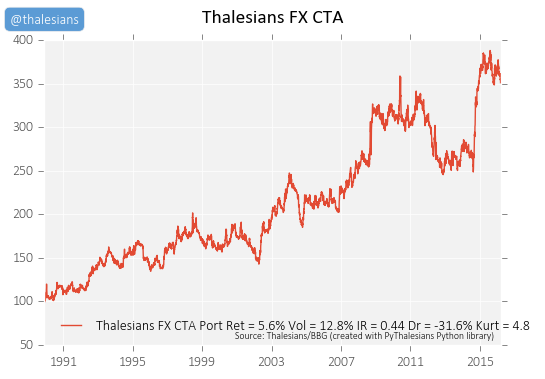

In [10]:
        strategy.plot_strategy_pnl()                        # plot the final strategy

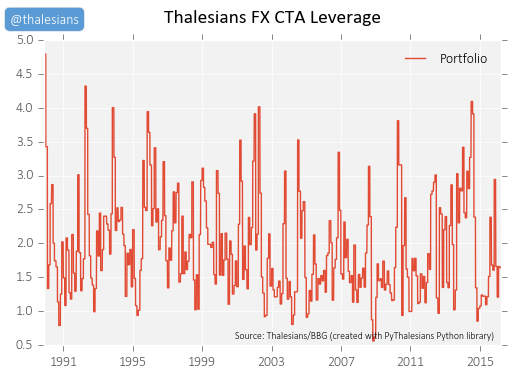

In [11]:
        strategy.plot_strategy_leverage()                   # plot the leverage of the portfolio

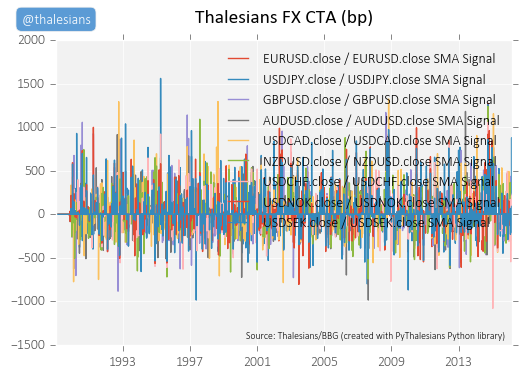

In [12]:
        strategy.plot_strategy_group_pnl_trades()           # plot the individual trade P&Ls

2016-03-21 14:30:08,949 - __main__ - INFO - Thalesians FX CTA Port Ret = 5.6% Vol = 12.8% IR = 0.44 Dr = -31.6% Kurt = 4.8
2016-03-21 14:30:08,950 - __main__ - INFO - EURUSD Port Ret = 5.3% Vol = 11.4% IR = 0.46 Dr = -28.3% Kurt = 2.89
2016-03-21 14:30:08,951 - __main__ - INFO - USDCHF Port Ret = 1.2% Vol = 12.0% IR = 0.1 Dr = -34.0% Kurt = 8.97
2016-03-21 14:30:08,951 - __main__ - INFO - AUDUSD Port Ret = 2.3% Vol = 12.5% IR = 0.18 Dr = -41.4% Kurt = 9.84
2016-03-21 14:30:08,952 - __main__ - INFO - USDJPY Port Ret = 2.9% Vol = 12.5% IR = 0.23 Dr = -48.8% Kurt = 6.77
2016-03-21 14:30:08,952 - __main__ - INFO - NZDUSD Port Ret = 2.4% Vol = 13.0% IR = 0.18 Dr = -41.0% Kurt = 10.75
2016-03-21 14:30:08,953 - __main__ - INFO - GBPUSD Port Ret = 2.0% Vol = 12.6% IR = 0.16 Dr = -38.9% Kurt = 4.71
2016-03-21 14:30:08,953 - __main__ - INFO - USDSEK Port Ret = 2.4% Vol = 12.0% IR = 0.2 Dr = -43.9% Kurt = 3.17
2016-03-21 14:30:08,953 - __main__ - INFO - USDCAD Port Ret = 1.2% Vol = 12.2% IR = 0.1

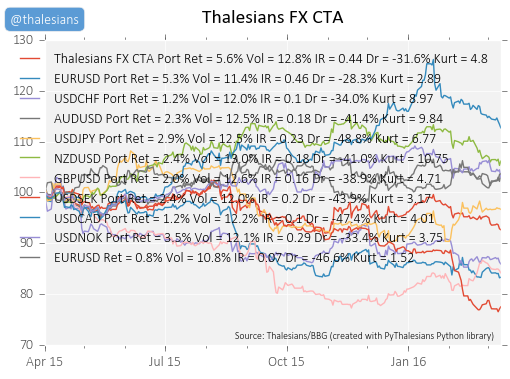

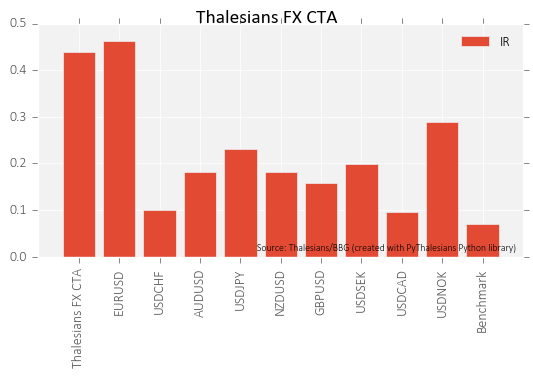

In [13]:
        strategy.plot_strategy_group_benchmark_pnl()        # plot all the cumulative P&Ls of each component

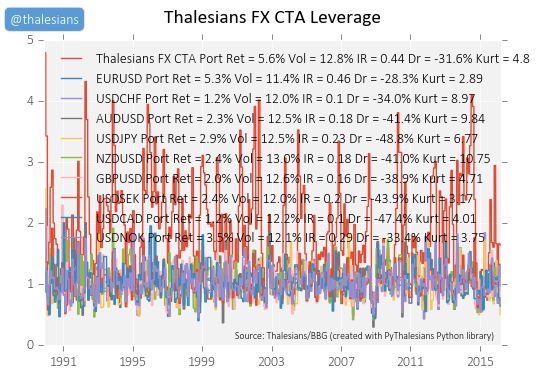

In [14]:
        strategy.plot_strategy_group_leverage()             # plot all the individual leverages

# Conclusion

We have shown a simple example of how to backtest a trading strategy with PyThalesians. 

# Doing sensitivity analysis for our trading strategy

To follow soon!